In [42]:
from curses import flash
import os
from pickle import TRUE
from re import L
import requests
import validators
import gzip
import shutil
from urllib.parse import urlparse

import sys
import math
import xarray as xa
import numpy as np
from rio_cogeo import cog_validate
import rioxarray

# Mapping
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [43]:
#main variables
base_path = '/home/asubedi/Desktop/hs3_temp_repo'
file_name = 'AE20130912.Gabrielle.loc.nc'
path = f'{base_path}/{file_name}'
engine = 'netcdf4'
var_name = 'Subset_Of_Stations'
split_range = 10000
current_setting = "Full"

In [44]:
#open file here
file1 = xa.open_dataset(path, engine=engine, decode_coords='all', decode_times=False)
#print(file1)

In [45]:
#lat, lon, data
latitude = file1.Latitude.data
longitude = file1.Longitude.data
data = file1[var_name].data

In [46]:
print(latitude, longitude, data)

[29.1102 28.7188 28.8607 ... 17.4299 17.3988 16.6186] [-65.2759 -65.3432 -65.3287 ... -68.1801 -67.982  -67.7445] [7 5 6 ... 4 6 2]


In [47]:
#split data/geolocation here -- if needed

split_lat = (np.copy(latitude[0:split_range]))
split_lon = (np.copy(longitude[0:split_range]))
split_data = (np.copy(data[0:split_range]))

In [48]:
split_dict = []
for i in range(len(split_data)):
    split_dict.append({
        "latitude":split_lat[i], 
        "longitude":split_lon[i],
        "data":split_data[i]
    })
print("Split_Dict Complete!!", len(split_dict))    

full_dict = []
for i in range(len(data)):
    full_dict.append({
        "latitude":latitude[i],
        "longitude":longitude[i],
        "data":data[i]
    })

print("Full_Dict Complete!!", len(full_dict))

Split_Dict Complete!! 6690
Full_Dict Complete!! 6690


In [49]:
#Sort geolocation here
full_sorted_lat = np.sort(np.copy(latitude), axis=0)
full_sorted_lon = np.sort(np.copy(longitude), axis=0)

split_sorted_lat = np.sort(np.copy(split_lat), axis=0)
split_sorted_lon = np.sort(np.copy(split_lon), axis = 0)

In [50]:
#init grid here
full_grid = np.zeros((len(latitude), len(latitude)))
split_grid = np.zeros((split_range, split_range))

In [51]:
def find_full_lat_lon(lat, lon):
    lat_index = None
    lon_index = None
    for i in range(len(full_sorted_lat)):
        if(full_sorted_lat[i] == lat):
            lat_index = i
            break;
    for i in range(len(full_sorted_lon)):
        if(full_sorted_lon[i] == lon):
            lon_index = i
            break;
    #print(lat_index, lon_index)
    return [lat_index, lon_index]
            
def find_split_lat_lon(lat, lon):
    lat_index = None
    lon_index = None
    for i in range(len(split_sorted_lat)):
        if(split_sorted_lat[i] == lat):
            lat_index = i
            break;
    for i in range(len(split_sorted_lon)):
        if(split_sorted_lon[i] == lon):
            lon_index = i
            break;
    return [lat_index, lon_index]

In [52]:
for di in full_dict:
    index = find_full_lat_lon(di["latitude"], di["longitude"])
    full_grid[index[0]][index[1]] = di["data"]

for di in split_dict:
    index = find_split_lat_lon(di["latitude"], di["longitude"])
    split_grid[index[0]][index[1]] = di["data"]

In [53]:
if(current_setting == 'Split'):
    new_xarray = xa.DataArray(
        data = split_grid,
        dims=("latitude", "longitude"),
        coords={
            "latitude":split_sorted_lat,
            "longitude":split_sorted_lon
        },
        attrs=dict(
            description="",
            units="",
        ),
    )
elif (current_setting == 'Full'):
    new_xarray = xa.DataArray(
        data = full_grid,
        dims=("latitude", "longitude"),
        coords={
            "latitude":full_sorted_lat,
            "longitude":full_sorted_lon
        },
        attrs=dict(
            description="",
            units="",
        ),
    )
else:
    print("Please select proper current_setting")

In [54]:
new_xarray = new_xarray.transpose('latitude', 'longitude')
new_xarray.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude', inplace=True)
new_xarray.rio.crs
new_xarray.rio.set_crs('epsg:4326', inplace=TRUE)
#new_xarray.plot()
cog_path = f'{base_path}/test-cog/alan{var_name}.tif'
new_xarray.rio.to_raster(rf'{cog_path}', driver='COG')


ERROR 1: PROJ: proj_create_from_database: /home/asubedi/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_name: /home/asubedi/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /home/asubedi/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
Warning 1: PROJ: proj_create_from_database: /home/asubedi/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


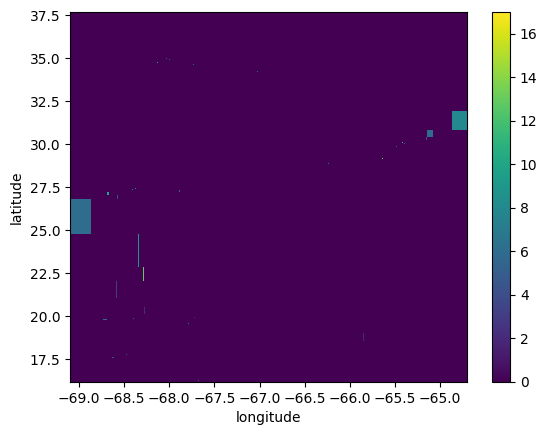